In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [ ]:
!pip install pandas==2.2.2 numpy==1.26.4
# ensure packages are installed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1


In [ ]:
# Load TensorBoard extension
%load_ext tensorboard

# Start TensorBoard
from datetime import datetime
import os

# Set up a log directory for TensorBoard
log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)


In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#INPORT DATA AND PREPROCESS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import os
import cv2
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision.utils
from torchvision import datasets, transforms
import numpy as np
# preprocessing steps
def preProcessing():
    LABELS_PATH = '/content/drive/My Drive/OCTDL_labels.csv'
    INPUT_PATH = '/content/drive/My Drive/OCTDL_AUGMENTED'
    OUTPUT_PATH = '/content/drive/My Drive/OCTDL_DCGAN_AUGMENTED'

    df = pd.read_csv(LABELS_PATH)

    dimensions = pd.DataFrame(df, columns = ['file_name', 'image_width', 'image_hight'])

    dimensions['z_width'] = zscore(dimensions['image_width'])
    dimensions['z_height'] = zscore(dimensions['image_hight'])

    z_threshold = 2.5

    filtered_dimensions = dimensions[
        (abs(dimensions['z_width']) <= z_threshold) &
        (abs(dimensions['z_height']) <= z_threshold)
    ].copy()


    filtered_dimensions['aspect_ratio'] = filtered_dimensions['image_width'] / filtered_dimensions['image_hight']
    avg_aspect_ratio = filtered_dimensions['aspect_ratio'].mean()

    # We are using A DCGAN
    # This is 64x64 by default
    # there is a way around this (see https://github.com/pytorch/examples/issues/70)
    # but when implementing it resulted in rapid mode collapse and failure to produce images
    height = 64
    width = 64
    target_size = (width, height)

    def resize_and_save(classname):
        input_dir = INPUT_PATH + '/augmented_data/' + classname
        output_dir = OUTPUT_PATH + '/' + classname

        os.makedirs(output_dir, exist_ok = True)

        for _, row in filtered_dimensions.iterrows():
                file_name = row['file_name'] + '.jpg'
                if classname.lower() not in file_name:
                    continue
                image_path = os.path.join(input_dir, file_name)

                # Read the image
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Error loading image {file_name}")
                    continue

                resized_img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)

                output_path = os.path.join(output_dir, file_name)
                cv2.imwrite(output_path, resized_img)

    classnames = ['AMD', 'DME', 'ERM', 'NO', 'RAO', 'RVO', 'VID']

    #for classname in classnames:
    #    resize_and_save(classname)


    # hyperparameters - to be adjusted
    # currently 80/20 split
    TEST_TRAIN_SPLIT = 0.2
    # we'll try 32 for now
    BATCH_SIZE = 32

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

    num_channels = 1 # used later when declaring generator/descriminator
    features_discrim = 16
    # 64 by 64 images
    dataset = datasets.ImageFolder(OUTPUT_PATH, transform=transform)

    #full preprocessed images
    #dataset = datasets.ImageFolder(INPUT_PATH, transform=transform)

    n_test = int(np.floor(TEST_TRAIN_SPLIT * len(dataset)))
    n_train = len(dataset) - n_test

    train_ds, test_ds = random_split(dataset, [n_train, n_test])

    train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
    test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 4)


    # some useful info about the dataset
    print(f"Classes: {dataset.classes}")
    print(f"Number of training samples: {len(train_ds)}")
    print(f"Number of testing samples: {len(test_ds)}")
    #for i, (x, label) in enumerate(train_dl):
        #print(label)
        #break
        #print(f"Image shape: {x.shape}")
    return train_dl, test_dl

#Making Explainable

In [ ]:
# This is the implementation of the explainable step within the code
import torch
from torch import Tensor, from_numpy, randn, full
from torch.autograd.variable import Variable

In [ ]:
# Credit to Ervans for the inital implementation of explainablity which was used as reference when transfering to this model
val = 0

def temp_store(value):
    global val
    val = value

def temp_get():
    global val
    return val

In [ ]:
def images_to_vectors(images: Tensor) -> Tensor:
    """ converts (Nx28x28) tensor to (Nx784) torch tensor """
    return images.view(images.size(0), 32 * 32)

def values_target(size: tuple, value: float, cuda: False) -> Variable:
    """ returns tensor filled with value of given size """
    result = Variable(full(size=size, fill_value=value))
    if cuda:
        result = result.cuda()
    return result

def normalize_vector(vector: torch.tensor) -> torch.tensor:
    """ normalize np array to the range of [0,1] and returns as float32 values """
    vector -= vector.min()
    vector /= vector.max()
    vector[torch.isnan(vector)] = 0
    return vector.type(torch.float32)

In [ ]:
from captum.attr import Saliency

def get_explanation(generated_data, discriminator, predicted_data, cuda=False, trained_data=None):

    # initialize temp values to all 1s
    temp = values_target(size=generated_data.size(), value=1.0, cuda=cuda)

    # mask values with low prediction
    mask = (predicted_data < 0.5).view(-1)
    indices = (mask.nonzero(as_tuple=False)).detach().cpu().numpy().flatten().tolist()

    data = generated_data[mask, :]
    #print(data.size())

    if len(indices) > 1:
        # XAI using saliency (maybe investigate others)
        for i in range(len(indices)):
            explainer = Saliency(discriminator)
            temp[indices[i], :] = explainer.attribute(data[i, :].detach().unsqueeze(0))
        #print(temp.size())

    # If using GPU, store the value into cuda storage
    if cuda:
        temp = temp.to("cuda")
    else:
        temp = temp.to("cpu")
    temp_store(normalize_vector(temp))

In [ ]:
def explanation_hook(module, grad_input, grad_output):
    explained_data = temp_get()
    #print(explained_data.size())

    """ Hook for explanation of the discriminator """
    #temp = images_to_vectors(explained_data)
    #print(temp.size())
    #temp = temp.to('cuda')

    new_grad = grad_input[0] + 0.2*(grad_input[0]*explained_data)
    new_grad = new_grad.to('cuda')

    return(new_grad,)

#Declaring Generator

In [ ]:
import torch
import torch.nn as nn
# declaration of the image generator.
# takes input Z of random noise
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html was used as a reference when creating this
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        num_channels = 1
        features_gen = 16
        self.main = nn.Sequential(

            # input is Z, going into a convolution
            nn.ConvTranspose2d( 100, features_gen * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_gen * 8),
            nn.ReLU(True),
            # state size. ``(features_gen*8) x 4 x 4``
            nn.ConvTranspose2d(features_gen * 8, features_gen * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_gen * 4),
            nn.ReLU(True),
            # state size. ``(features_gen*4) x 8 x 8``
            nn.ConvTranspose2d( features_gen * 4, features_gen * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_gen * 2),
            nn.ReLU(True),
            # state size. ``(features_gen*2) x 16 x 16``
            nn.ConvTranspose2d( features_gen * 2, features_gen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_gen),
            nn.ReLU(True),
            # state size. ``(features_gen) x 32 x 32``
            nn.ConvTranspose2d( features_gen, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(num_channels) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

device = "cuda" if torch.cuda.is_available() else "cpu"
# Create the generator
netG = Generator(1).to(device)

# Handle multi-GPU if desired
#if (device.type == 'cuda') and (ngpu > 1):
#    netG = nn.DataParallel(netG, list(range(ngpu)))


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper https://arxiv.org/pdf/1511.06434
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(initialize_weights)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#Declaring Discriminator

In [ ]:
# creating the discriminatior that will determine if an image is generated or
# one of the original images
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html was used as a reference when creating this
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        num_channels = 1
        features_discrim = 16
        self.main = nn.Sequential(
            # input is ``(num_channels) x 64 x 64``
            nn.Conv2d(num_channels, features_discrim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(features_discrim) x 32 x 32``
            nn.Conv2d(features_discrim, features_discrim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_discrim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(features_discrim*2) x 16 x 16``
            nn.Conv2d(features_discrim * 2, features_discrim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_discrim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(features_discrim*4) x 8 x 8``
            nn.Conv2d(features_discrim * 4, features_discrim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_discrim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(features_discrim*8) x 4 x 4``
            nn.Conv2d(features_discrim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

device = "cuda" if torch.cuda.is_available() else "cpu"
# Create the Discriminator
netD = Discriminator(1).to(device)

# Handle multi-GPU if desired
#if (device.type == 'cuda') and (ngpu > 1):
#    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``initialize_weights`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(initialize_weights)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


#initialise loss function and optimisers

In [ ]:
import torch.optim as optim
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Set learning rate
LEARNING_RATE = 0.0002

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [ ]:
# create gradient penalty
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

#Begin Training

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 200
EXPLANATION_EPOCH = 10
CRITIC_ITERATIONS = 5
Z_DIM = 100
#load in data into dataloader
train_d1, test_d1, = preProcessing()
dataloader = train_d1
LAMBDA_GP = 10
trained_data = Variable(next(iter(train_d1))[0])

# for logging:
collect_x_gen = []
fixed_noise = torch.randn(32, Z_DIM, 1, 1, device=device).detach()
fig = plt.figure() # keep updating this one
plt.ion()

step = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):

    # Every 10 epochs, explanation used to redirect the gradient closer to real images
    if epoch % EXPLANATION_EPOCH == 0 and epoch != 0:
        print(f"Epoch {epoch} - Explanation")
        netG.register_backward_hook(explanation_hook)

    for batch_idx, (real, _) in enumerate(train_d1):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        # Train D: max E[D(real)] - E[D(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = netG(noise)
            D_real = netD(real).reshape(-1)
            D_fake = netD(fake).reshape(-1)
            gp = gradient_penalty(netD, real, fake, device=device)
            loss_D = (
                -(torch.mean(D_real) - torch.mean(D_fake)) + LAMBDA_GP * gp
            )
            netD.zero_grad()
            loss_D.backward(retain_graph=True)
            optimizerD.step()

        # Train Generator: max E[D(gen_fake)] <-> min -E[D(gen_fake)]

        gen_fake = netD(fake).reshape(-1)

        get_explanation(fake, netD, gen_fake, cuda=True, trained_data=trained_data)

        loss_gen = -torch.mean(gen_fake)
        netG.zero_grad()
        loss_gen.backward()
        optimizerG.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 44 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx+1}/{len(train_d1)} \
                  Loss D: {loss_D:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = netG(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                #writer_real.add_image("Real", img_grid_real, global_step=step)
                #writer_fake.add_image("Fake", img_grid_fake, global_step=step)

                output_path = "fake_image.png"
                torchvision.utils.save_image(img_grid_fake, output_path)

                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)

                output_path = "fake_image1.png"
                torchvision.utils.save_image(img_grid_fake, output_path)
                #files.download(output_path)

            step += 1

Classes: ['AMD', 'DME', 'ERM', 'NO', 'RAO', 'RVO', 'VID']
Number of training samples: 1440
Number of testing samples: 616


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Starting Training Loop...


/usr/local/lib/python3.11/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


Epoch [0/200] Batch 45/45                   Loss D: -0.0822, loss G: -0.4558
Epoch [1/200] Batch 45/45                   Loss D: -0.5136, loss G: -0.1450
Epoch [2/200] Batch 45/45                   Loss D: -0.8616, loss G: -0.0626
Epoch [3/200] Batch 45/45                   Loss D: -0.9278, loss G: -0.0296
Epoch [4/200] Batch 45/45                   Loss D: -0.9286, loss G: -0.0203
Epoch [5/200] Batch 45/45                   Loss D: -0.8837, loss G: -0.0243
Epoch [6/200] Batch 45/45                   Loss D: 0.0340, loss G: -0.4540
Epoch [7/200] Batch 45/45                   Loss D: -0.5278, loss G: -0.1960
Epoch [8/200] Batch 45/45                   Loss D: -0.3175, loss G: -0.4436
Epoch [9/200] Batch 45/45                   Loss D: -0.5959, loss G: -0.1255
Epoch 10 - Explanation


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch [10/200] Batch 45/45                   Loss D: -0.6420, loss G: -0.1151
Epoch [11/200] Batch 45/45                   Loss D: -0.6947, loss G: -0.1242
Epoch [12/200] Batch 45/45                   Loss D: -0.6786, loss G: -0.1646
Epoch [13/200] Batch 45/45                   Loss D: -0.6411, loss G: -0.1969
Epoch [14/200] Batch 45/45                   Loss D: -0.6425, loss G: -0.1613
Epoch [15/200] Batch 45/45                   Loss D: -0.5646, loss G: -0.1437
Epoch [16/200] Batch 45/45                   Loss D: -0.2172, loss G: -0.4606
Epoch [17/200] Batch 45/45                   Loss D: -0.7924, loss G: -0.0888
Epoch [18/200] Batch 45/45                   Loss D: -0.5792, loss G: -0.1830
Epoch [19/200] Batch 45/45                   Loss D: -0.8020, loss G: -0.0601
Epoch 20 - Explanation
Epoch [20/200] Batch 45/45                   Loss D: -0.6160, loss G: -0.1074
Epoch [21/200] Batch 45/45                   Loss D: -0.8282, loss G: -0.0816
Epoch [22/200] Batch 45/45               

<Figure size 640x480 with 0 Axes>

#Plot Results

In [ ]:
from PIL import Image

noise = torch.randn(1, Z_DIM, 1, 1).to(device)
fake=netG(noise)
torchvision.utils.save_image(fake, "fakeimage1.png")
im = Image.open("fakeimage1.png")

newsize = (546,199)
im1 = im.resize(newsize)
# Shows the image in image viewer
im1.save("fakeimage2.png")

In [ ]:
for i in range(0, 2056):
    noise = torch.randn(1, Z_DIM, 1, 1).to(device)
    fake = netG(noise)

    output_path = ""
    torchvision.utils.save_image(fake, output_path)

ValueError: unknown file extension: 

 save the models

In [ ]:
torch.save(netG.state_dict, '/content/drive/My Drive/OCTDL_DCGAN_AUGMENTED/netG.pth')
torch.save(netD.state_dict, '/content/drive/My Drive/OCTDL_DCGAN_AUGMENTED/netD.pth')
torch.save(netG, '/content/drive/My Drive/OCTDL_DCGAN_AUGMENTED/netGfull.pth')
torch.save(netD, '/content/drive/My Drive/OCTDL_DCGAN_AUGMENTED/netDfull.pth')
netG.eval()
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

example comparison

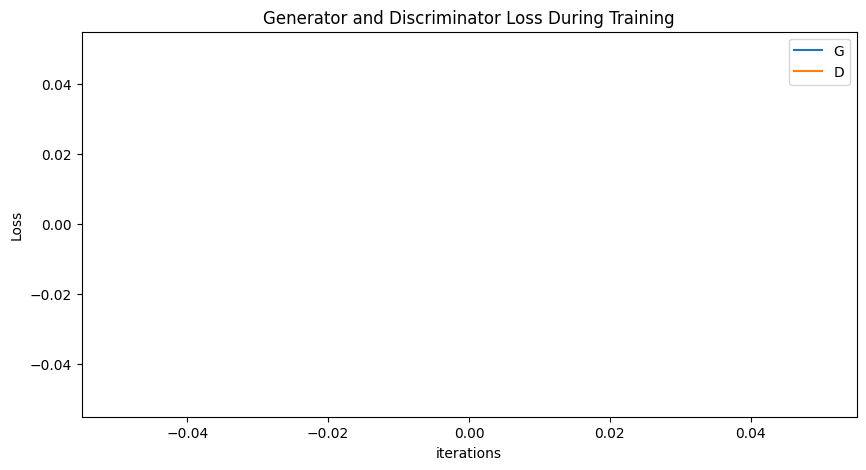

IndexError: list index out of range

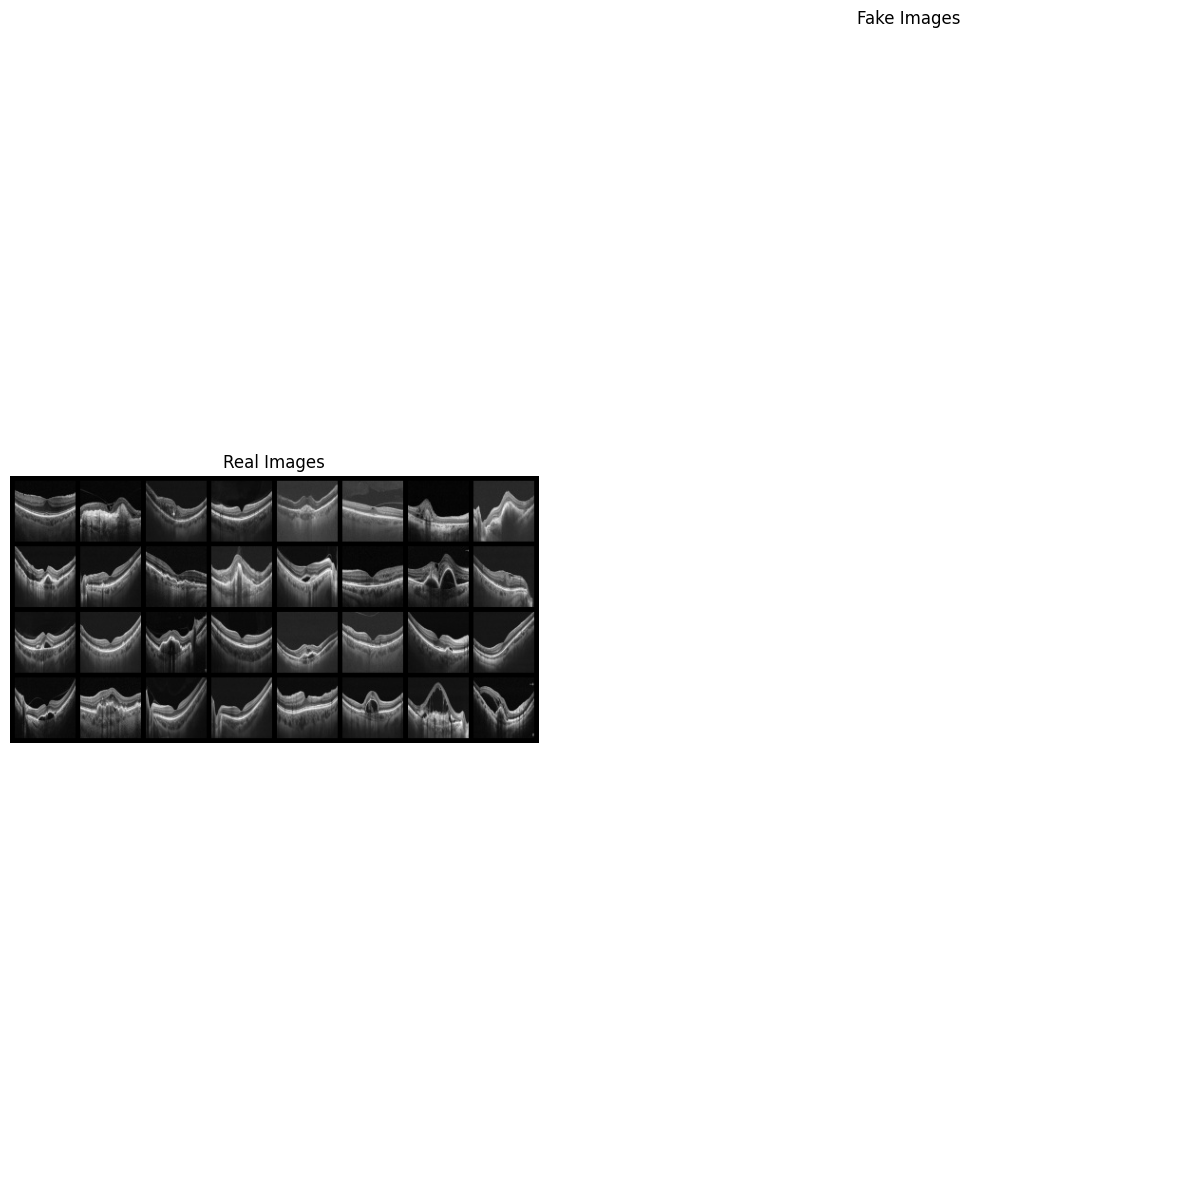

In [ ]:

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()